# pyDeepInsight Discretization Methods Tutorial

This tutorial introduces the various discretization methods available in **pyDeepInsight**. Discretization is the process by which the output from feature reduction manifolds (e.g., t-SNE) is mapped onto pixel space. The default method, `bin`, can lead to **mapping collisions**, where multiple features are assigned to the same pixel. To address this, pyDeepInsight provides several alternative discretization methods that aim to reduce such overlap.

---

## Scaling-based Methods

### **Binning (`bin`)**
Scales the component values to match the pixel space and assigns each feature to the pixel it falls within.

### **Quantile Transformation Binning (`qtb`)**
Applies a [quantile transformation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.quantile_transform.html) independently to each component dimension, with the number of quantiles equal to the number of pixels in that dimension. Features are then assigned based on their transformed values. This method still allows collisions, but typically fewer than `bin`.

---

## Assignment-based Methods

The following methods compute a feature-to-pixel distance matrix and solve the [assignment problem](https://en.wikipedia.org/wiki/Assignment_problem) to minimize total assignment distance, ensuring each feature is mapped to a unique pixel. If there are more features than available pixels, **bisecting k-means** clustering is applied first, reducing the number of features to match the number of pixels.

### **Linear Sum Assignment (`lsa`)**
Uses SciPy's [linear sum assignment](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html) implementation to find the optimal mapping. For large matrices, this method can be extremely slow or infeasible due to high memory and time demands.

### **Sparse Linear Assignment (`sla`)**
Selects the top third of lowest-cost assignments and applies SciPy’s [minimum weight full matching](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.min_weight_full_bipartite_matching.html) on a bipartite graph. It’s faster and uses less memory than `lsa`, but can fail if no complete matching is possible (i.e., if the sparse matrix is unsolvable).

### **Asymmetric Greedy Search (`ags`)**
Implements the heuristic proposed in *[A heuristic for the time constrained asymmetric linear sum assignment problem](https://doi.org/10.1007/s10878-015-9979-2)* by Brown et al. (2015). This method is designed for time-constrained scenarios where `lsa` and `sla` are too slow or fail. According to the authors, `ags` typically achieves results within 0.1% of the optimal solution.

---

## What This Tutorial Covers

In this tutorial, we will:

- Apply these methods to generate 16 × 16 pixel images for visualization
- Measure and compare the runtime of each method across varying image sizes (from 16 × 16 to 224 × 224)



In [1]:
from pyDeepInsight import ImageTransformer
import numpy as np
import copy

from sklearn.decomposition import PCA
from sklearn.datasets import make_classification, make_blobs
from scipy.spatial.distance import euclidean

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Helper Functions
### Dataset contruction and transformation

In [3]:
def create_dataset(pixels, p_features):
    """Create a synthetic dataset and initialize an ImageTransformer 
    for feature reduction."""
    it = ImageTransformer(
        #feature_extractor=KernelPCA(n_components=2, kernel='rbf', gamma=0.001),
        feature_extractor=PCA(n_components=2),
        pixels=pixels, 
        discretization='bin')
    n_features = int(np.prod(pixels)*p_features)
    X, y = make_blobs(n_samples=1000, n_features=n_features, centers=int(n_features*0.2), random_state=42)
    # MinMaxScale
    X = (X - X.min())/(X.max() - X.min())
    return it, X

In [4]:
def plot_assignment(imtr, ax=None, title=None):
    """Plot the feature density matrix and the feature-to-pixel assignments."""
    if ax is None:
        ax = plt.gca()
    fdm = imtr.feature_density_matrix()
    _ = sns.heatmap(fdm, linewidths=0.5,
                    linecolor='lightgray', cbar=False,
                    xticklabels=False, yticklabels=False,
                    annot=True,
                    cmap="Blues", square=True, clip_on=False,
                    vmin=0, vmax=5, ax=ax)
    # Overlap Index
    overlap_index = np.sum((fdm[fdm > 1] - 1)**2) / np.prod(imtr.pixels)
    # mapping arrows
    oc = imtr._coords
    os = imtr.scale_coordinates(imtr._xrot, imtr._pixels)
    total_dist = 0
    for i in range(oc.shape[0]):
        px, py, dx, dy = os[i,1], os[i,0], (oc[i,1]+0.5)-os[i,1], (oc[i,0]+0.5)-os[i,0]
        ax.quiver(px, py, dx, dy, width=.004, scale_units='xy',
                  angles='xy', scale=1, color="darkred")
        total_dist += np.abs(dx) + np.abs(dy)
    ax.set_title(f"{title}\nDist={total_dist/oc.shape[0]:.2f} OI={overlap_index:0.2f}")

In [5]:
def desc_comparison_plot(it, X):
    """Generate a comparison plot of different discretization methods."""
    fig, axs = plt.subplots(2, 3, figsize=(10, 7), layout='constrained')

    plt.sca(axs[0,0])
    _ = it.fit(X, plot=True)
    it._fe = None
    axs[0,0].set_title("Reduced Feature Space\nw/ Bounding Rectangle")

    for i, disc_method in enumerate(disc_methods):
        ax = axs.flat[i+1]
        try:
            plot_assignment(change_discretization(it, disc_method), ax, disc_method)
        except:
            pass
    for ax in axs.flat:
        _ = ax.axis('off')

In [6]:
def change_discretization(imtr, discretization):
    """Update the discretization method of an ImageTransformer and 
    recalculate the mapping."""
    imtr = copy.deepcopy(imtr)
    imtr._dm = it._parse_discretization(discretization)
    imtr._calculate_coords()
    return imtr
    

### Timing

In [7]:
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp
import time
import pandas as pd
import random
from tqdm import tqdm

def generate_image_transformers(p_features):
    """Generate a dictionary of ImageTransformer objects for varying 
    pixel dimensions."""
    its = {}
    for pixels in list(range(16, 224+1, 16)):
        it, X = create_dataset((pixels, pixels), p_features)
        _ = it.fit(X)
        it._fe = None
        its[pixels] = copy.deepcopy(it)
    return its

def measure_time_discretization(it, method):
    """Measure the time taken to update the discretization method."""
    start_time = time.time()
    change_discretization(it, method)
    return time.time() - start_time

def time_discretization_with_pool(it, method, timeout=60):
    """Measure the time to apply a discretization method with a timeout constraint."""
    with mp.Pool(1) as pool:
        async_result = pool.apply_async(measure_time_discretization, (it, method))
        try:
            return async_result.get(timeout)
        except:
            return -1

def measure_time_with_timeout(task):
    """Execute and measure the time taken for a discretization task with timeout handling."""
    method, pixels, it, timeout = task
    return (method, pixels, time_discretization_with_pool(it, method, timeout))

def get_timings(it_map, disc_methods, timeout=10, num_repeats=5):
    """Measure and collect timing data for various discretization methods across 
    pixel sizes."""
    combinations = [(method, pixels) for pixels in it_map.keys() for method in disc_methods] * num_repeats
    tasks = [(method, pixels, it_map[pixels], timeout) for method, pixels in combinations]
    random.shuffle(tasks)

    timings = []
    with ProcessPoolExecutor(max_workers=5) as executor:
        for method, pixels, timing in tqdm(executor.map(measure_time_with_timeout, tasks), total=len(tasks)):
            timings.append((method, pixels, timing))
    return pd.DataFrame([{'method': method, 'pixels': pixels, 'timing': timing}
                         for method, pixels, timing in timings])

def plot_timings(timings):
    """Plot the timing results of discretization methods for different pixel sizes."""
    timings = timings[timings.timing > 0].groupby(['method', 'pixels']).mean().reset_index()
    fig, axs = plt.subplots(1,2, figsize=(10, 3), sharex=True, layout='constrained')
    sns.lineplot(data=timings, x='pixels', y='timing', hue='method', marker='o', ax=axs[0], legend=False)
    sns.lineplot(data=timings, x='pixels', y='timing', hue='method', marker='o', ax=axs[1])
    axs[1].set_yscale("log")
    axs[1].set_ylabel(None)
    handles, labels = axs[1].get_legend_handles_labels()
    axs[1].get_legend().remove()
    fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), frameon=False)

In [8]:
disc_methods = ['bin', 'qtb', 'lsa', 'sla', 'ags']
img_size = (16, 16)

## Discretization Comparison

This section compares the available discretization methods using visual plots of 
**feature-to-pixel mappings** on **16 × 16 pixel** image examples.

We introduce two evaluation metrics to assess the quality of the final assignments:

1. **Distance (Dist)**: The **sum of Euclidean distances** between each feature's original 
position in the manifold (e.g., t-SNE output) and the center of the pixel to which it was 
assigned. This quantifies how much the spatial structure of the data is preserved.

2. **Overlap Index (OI)**: Calculated as the **sum of the squares** of the number of features 
assigned to each pixel (minus one), divided by the total number of pixels. This metric measures 
the degree of **feature collision**, where multiple features occupy the same pixel.

The **Dist** metric emphasizes spatial fidelity, while **OI** highlights mapping overlap.

---

### Features < Pixels

In this first scenario, we examine cases where the number of features is **less than** the number 
of available pixels. Specifically, we simulate a situation where the number of features is **50% of 
the total pixels**.

This is a common setup when generating image-like inputs for pre-trained convolutional neural 
networks (CNNs), where image sizes (e.g., **224 × 224**, totaling **50,176** pixels) typically far 
exceed the number of input features.


In [9]:
p_features = 0.5
it, X = create_dataset(img_size, p_features)

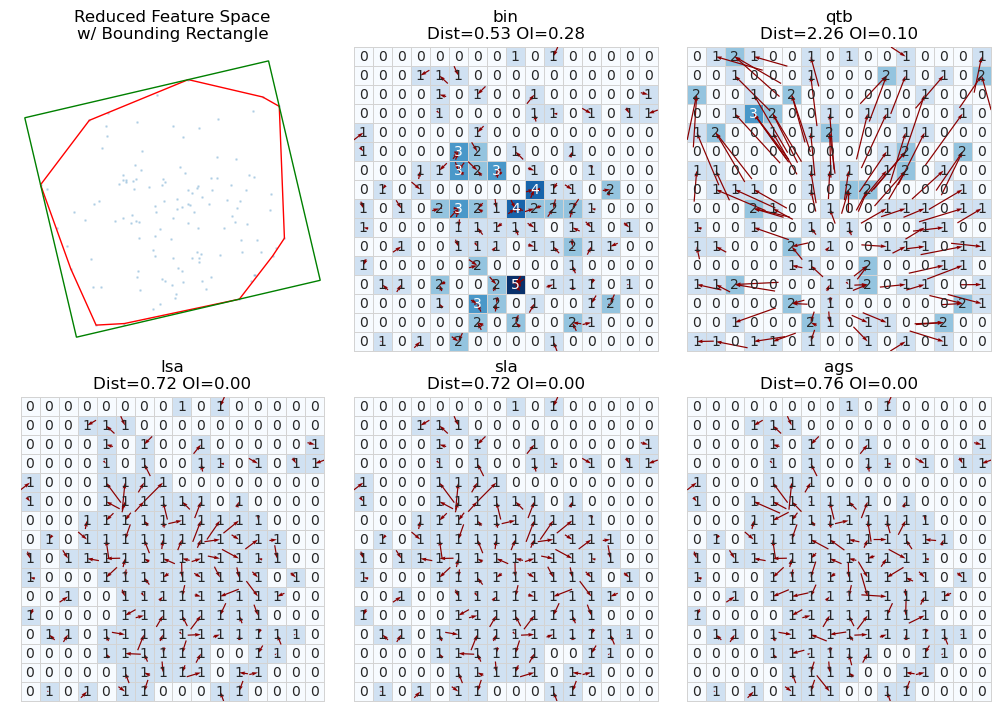

In [10]:
desc_comparison_plot(it, X)

As expected, the **Overlap Index (OI)** for all assignment-based methods is **zero**, since each feature is assigned to a unique pixel.

The **qtb** method substantially reduces overlap compared to the default **bin** method, but this comes at the cost of a significantly higher total distance (**Dist**), reflecting greater distortion of the original feature space.

The heuristic **ags** method results in a slightly higher total distance than the optimal **lsa** method, but it remains computationally efficient and avoids the excessive runtimes that make **lsa** impractical for larger datasets.


In [11]:
its = generate_image_transformers(p_features)

In [12]:
timeout = 60 * 60
num_repeats = 3
timings = get_timings(its, disc_methods, timeout=timeout, num_repeats=num_repeats)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [5:57:31<00:00, 102.15s/it]


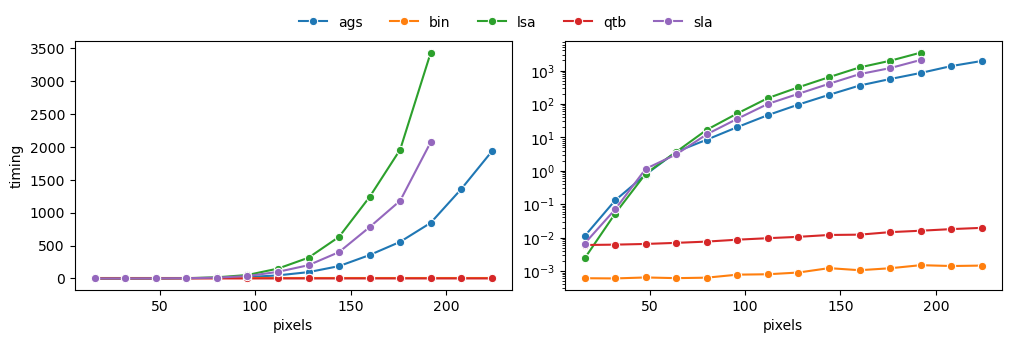

In [13]:
plot_timings(timings)

Each algorithm was given a **maximum runtime of one hour per execution**, and timings were **repeated three times**. The plots show the **mean runtime** across these runs.

Both **bin** and **qtb** display near-constant runtimes across dataset sizes due to their simple, direct implementation.

Among the assignment-based methods, **ags** consistently outperforms both **lsa** and **sla** in terms of speed at larger image sizes, making it the most practical option for high-dimensional feature-to-pixel mappings.

---

### Features = Pixels

The second scenario explores cases where the number of features is **equal to** the number of pixels.


In [14]:
p_features = 1.
it, X = create_dataset(img_size, p_features)

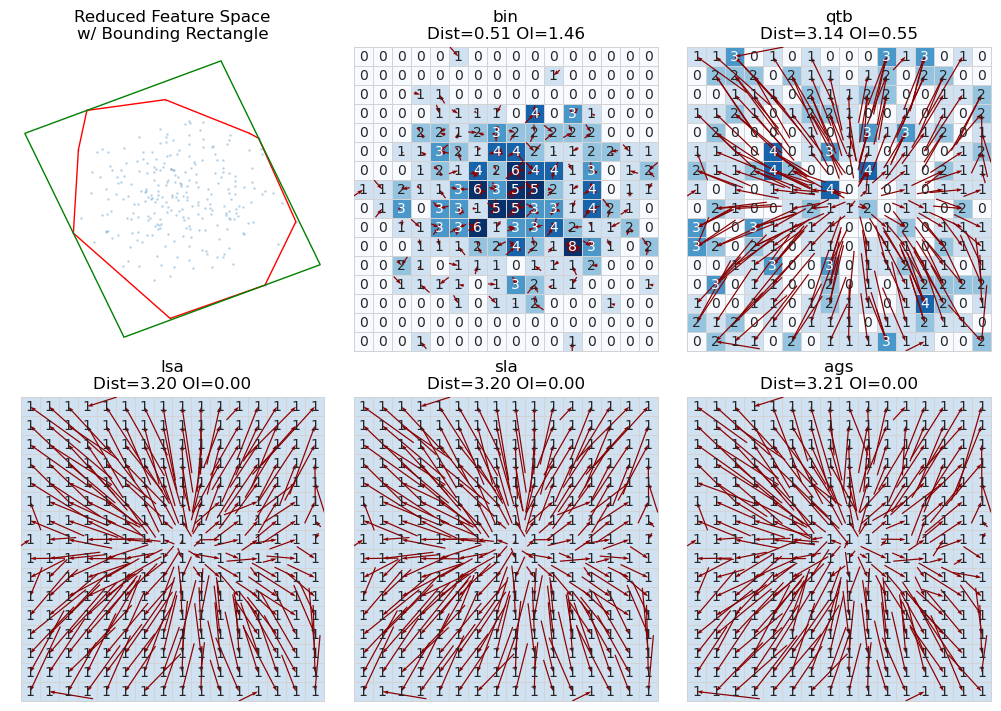

In [15]:
desc_comparison_plot(it, X)

The three assignment-based methods (**ags**, **lsa**, and **sla**) perform comparably, 
with **ags** incurring a slightly higher total distance.

The **qtb** method significantly reduces the overlap index compared to the default **bin** method, 
while maintaining a total distance comparable to the assignment-based methods.


In [16]:
its = generate_image_transformers(p_features)

In [17]:
timings = get_timings(its, disc_methods, timeout=timeout, num_repeats=num_repeats)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [14:22:10<00:00, 246.34s/it]


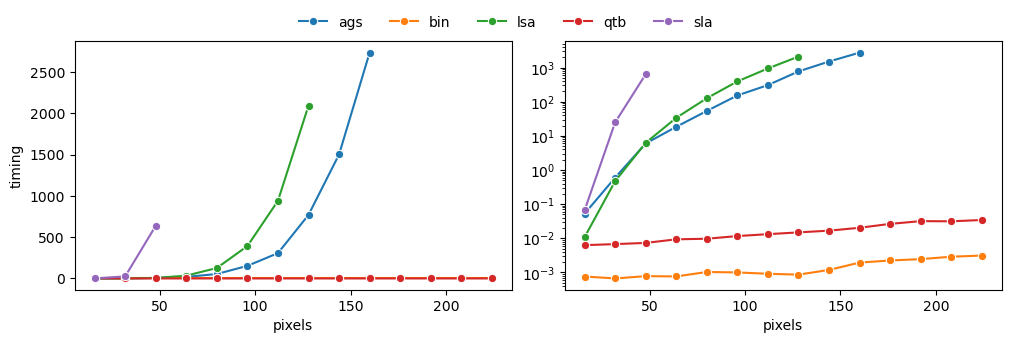

In [18]:
plot_timings(timings)

The huerstic assignment method, **ags**, becomes markedly faster 
than the other assignment methods beyond 96 pixels. It is also the only method 
consistently able to complete assignments for larger datasets within the 
allowed time limi.



### #Features > #Pixels

The third scenario examines cases where the number of features exceeds the number 
of available pixels.

To handle this, the assignment-based methods first cluster the features into 
**k** groups (where **k** equals the number of pixels) using bisecting k-means. 
The assignment algorithm is then applied to the cluster centroids rather than 
individual features.
    

In [19]:
p_features = 1.2
it, X = create_dataset(img_size, p_features)

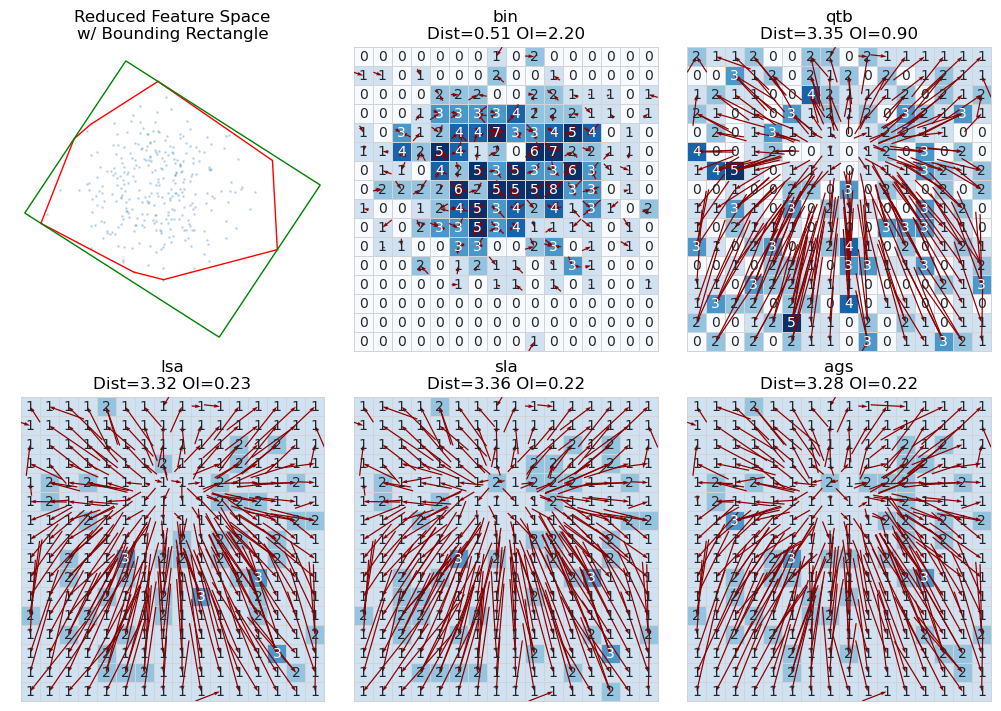

In [20]:
desc_comparison_plot(it, X)

In [21]:
its = generate_image_transformers(p_features)

In [22]:
timings = get_timings(its, disc_methods, timeout=timeout, num_repeats=num_repeats)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [26:00:04<00:00, 445.73s/it]


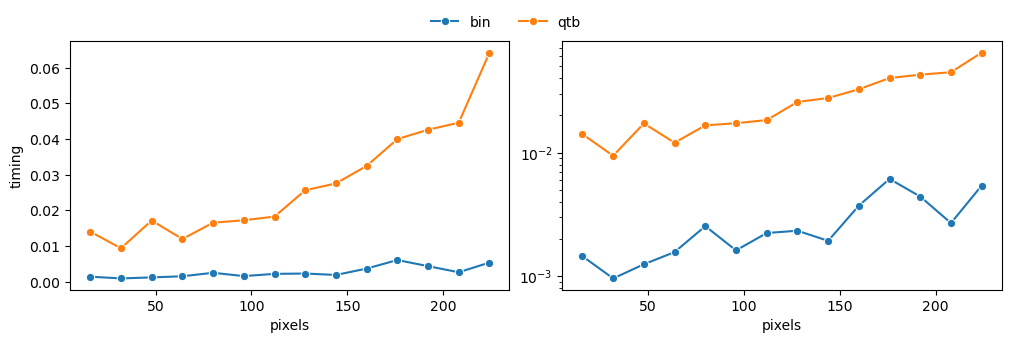

In [23]:
plot_timings(timings)

For this final scenario, none of the assignment methods completed within 
the allowed time limit. This outcome is likely due to the additional 
computational overhead introduced by the clustering step, which is required 
to reduce the number of features to match the number of available pixels 
before assignment.

---

## Conclusion

This tutorial introduced and compared the discretization methods available in pyDeepInsight, highlighting their trade-offs in terms of mapping accuracy, collision avoidance, and computational efficiency. 

While the **bin** and **qtb** methods offer simplicity and speed, the assignment-based methods (**lsa**, **sla**, and **ags**) ensure unique feature placement with lower overlap—at the cost of increased runtime. Among them, **ags** emerges as a practical default for large datasets due to its balance of performance and speed.

Choosing the best method depends on your dataset size, feature dimensionality, and runtime constraints. We encourage users to benchmark these methods on their own data and select the one best aligned with their application goals.